<a href="https://colab.research.google.com/github/anuragbantu/DL-Assignment-1/blob/main/Assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


from keras.datasets import fashion_mnist




**Question 1**

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

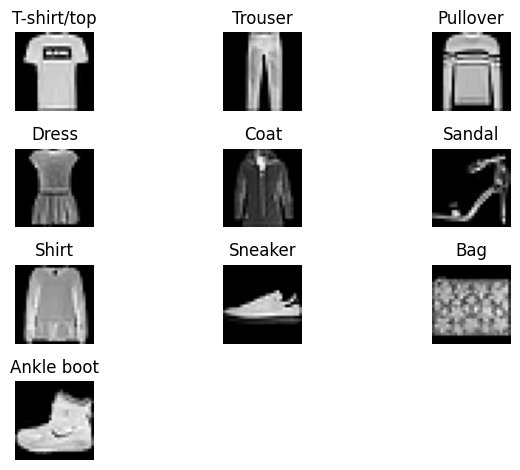

In [6]:
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(4, 3, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(class_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Question 2**

preparing the dataset.

In [7]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.0



In [8]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1

    encoded = np.zeros((len(labels), num_classes))

    encoded[np.arange(len(labels)), labels] = 1

    return encoded

y_train = one_hot_encode(y_train)


In [9]:
y_test = one_hot_encode(y_test)

In [10]:
y_train.shape

(60000, 10)

In [11]:
x_train.shape

(60000, 28, 28, 1)

Define a class for layers.

In [28]:
def sigmoid(x):
  return 0.5 * (1 + np.tanh(0.5 * x))

def sigmoid_d(x):
  s= sigmoid(x)
  return s*(1-s)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True) + 1e-8)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_d(x):
    diag_s = np.diag(x)

    outer_s = np.outer(x, x)
    return diag_s - outer_s

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return np.where(x > 0, 1, 0)

#CCE loss function
def categorical_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
    return np.mean(loss)

#MSE loss
def squared_error_loss(y_true, y_pred):
    return (np.mean(np.sum((y_true - y_pred) ** 2, axis=1))/2)

activations = {"sigmoid":sigmoid,"softmax":softmax,"tanh":tanh,"relu":relu}

derivatives = {"sigmoid":sigmoid_d}





In [13]:
class layer:
  def __init__(self, input, neurons, activation, weight_init):
    if weight_init == "xavier":
        self.weights = np.random.randn(input, neurons) * np.sqrt(1 / input)
    else:
        self.weights = np.random.randn(input, neurons)
    self.bias = np.zeros((1, neurons))
    self.activation = activations[activation]
    self.activation_d = derivatives.get(activation, None)

  def forward(self, a_prev):
    self.a_prev = a_prev
    self.z = np.dot(self.a_prev,self.weights) + self.bias
    self.a = self.activation(self.z)
    return self.a

  def sgd(self,w_d,b_d,lr):
    self.weights -= lr*w_d
    self.bias -= lr*b_d

  def momentum_gd(self, w_d, b_d, lr, momentum=0.9):
    if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
    if not hasattr(self, 'm_b'):
        self.m_b = np.zeros_like(self.bias)
    self.m_w = momentum * self.m_w + lr * w_d
    self.m_b = momentum * self.m_b + lr * b_d
    self.weights -= self.m_w
    self.bias -= self.m_b

  def nesterov_gd(self, w_d, b_d, lr, momentum=0.9):
      if not hasattr(self, 'm_w'):
          self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      m_w_prev, m_b_prev = self.m_w, self.m_b
      self.m_w = momentum * self.m_w + lr * w_d
      self.m_b = momentum * self.m_b + lr * b_d
      self.weights -= momentum * m_w_prev + (1 + momentum) * self.m_w
      self.bias -= momentum * m_b_prev + (1 + momentum) * self.m_b

  def rmsprop(self, w_d, b_d, lr, decay_rate=0.9, epsilon=1e-8):
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      self.v_w = decay_rate * self.v_w + (1 - decay_rate) * np.square(w_d)
      self.v_b = decay_rate * self.v_b + (1 - decay_rate) * np.square(b_d)
      self.weights -= lr * w_d / (np.sqrt(self.v_w) + epsilon)
      self.bias -= lr * b_d / (np.sqrt(self.v_b) + epsilon)

  def adam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):

      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0

      self.t += 1

      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      self.weights -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

  def nadam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0
      self.t += 1
      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      m_w_bar = beta1 * m_w_hat + ((1 - beta1) / (1 - beta1**self.t)) * w_d
      m_b_bar = beta1 * m_b_hat + ((1 - beta1) / (1 - beta1**self.t)) * b_d
      self.weights -= lr * m_w_bar / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_bar / (np.sqrt(v_b_hat) + epsilon)

  def backprop(self, a_d, lr, optimizer):
    if self.activation_d:
      z_d = np.multiply(self.activation_d(self.z),a_d)
    else:
      z_d = a_d
    w_d = np.dot(self.a_prev.T,z_d)
    b_d = np.sum(z_d,axis=0,keepdims=True)
    a_prev_d = np.dot(z_d,self.weights.T)

    if optimizer == 'sgd':
            self.sgd(w_d, b_d, lr)
    elif optimizer == 'momentum':
        self.momentum_gd(w_d, b_d, lr)
    elif optimizer == 'nesterov':
        self.nesterov_gd(w_d, b_d, lr)
    elif optimizer == 'rmsprop':
        self.rmsprop(w_d, b_d, lr)
    elif optimizer == 'adam':
        self.adam(w_d, b_d, lr)
    elif optimizer == 'nadam':
        self.nadam(w_d, b_d, lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    return a_prev_d


#layers = [layer(784,128,"sigmoid"),layer(128,128,"sigmoid"),layer(128,10,"softmax")]

# Question 3

Implement backpropagation algorithm

# Question 4


In [14]:
!pip install wandb -Uq

In [15]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [16]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },

    'lr': {
          'values': [0.001, 0.01, 0.1]
        },
    }

sweep_config['parameters'] = parameters_dict

In [17]:
sweep_id = wandb.sweep(sweep_config, project="dla1-sweeps")

Create sweep with ID: c7nfo990
Sweep URL: https://wandb.ai/ma24m003-iit-madras/dla1-sweeps/sweeps/c7nfo990


In [18]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [19]:
x_train.shape

(54000, 28, 28, 1)

In [20]:
x_val.shape

(6000, 28, 28, 1)

In [21]:
import wandb
import numpy as np

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'fc_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'lr': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))





Create sweep with ID: s1laeox9
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/s1laeox9


In [22]:
x_test.shape

(10000, 28, 28)

In [23]:
x_val.shape

(6000, 28, 28, 1)

In [30]:
def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = categorical_cross_entropy(y_batch, a)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = categorical_cross_entropy(y_val, a_val)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = categorical_cross_entropy(y_test, a_test)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(sweep_id, train_network, count=10)

wandb.finish()


wandb: Agent Starting Run: 7o3raz1c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.682457193362066, Accuracy: 0.7567220245156188, val_loss: 0.6661402206725614, val_accuracy: 0.7685
Epoch 2, Loss: 0.5878430962898784, Accuracy: 0.7921053281929616, val_loss: 0.5964360990883232, val_accuracy: 0.7886666666666666
Epoch 3, Loss: 0.5558914583953999, Accuracy: 0.8033437129300118, val_loss: 0.5755131254882285, val_accuracy: 0.793
Epoch 4, Loss: 0.5769518021389538, Accuracy: 0.7949288256227758, val_loss: 0.5983487531879648, val_accuracy: 0.7778333333333334
Epoch 5, Loss: 0.6148587146404698, Accuracy: 0.7755906484776591, val_loss: 0.62986536260625, val_accuracy: 0.7736666666666666
Test Loss: 0.6867898209157104, Test Accuracy: 0.7587


accuracy,▁▆█▇▄
epoch,▁▃▅▆█
loss,█▃▁▂▄
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇█▄▂
val_loss,█▃▁▃▅
accuracy,0.77559
epoch,5
loss,0.61486
test_accuracy,0.7587


wandb: Agent Starting Run: dx3w9pvg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.7441573788502007, Accuracy: 0.7321631573744563, val_loss: 0.6201640847701646, val_accuracy: 0.7746666666666666
Epoch 2, Loss: 0.6174012267307133, Accuracy: 0.782936684460261, val_loss: 0.5953278476723918, val_accuracy: 0.7898333333333334
Epoch 3, Loss: 0.5980390208000861, Accuracy: 0.789108837485172, val_loss: 0.5928631945227851, val_accuracy: 0.7866666666666666
Epoch 4, Loss: 0.5849899983277186, Accuracy: 0.7910055852115461, val_loss: 0.5907492874753999, val_accuracy: 0.7836666666666666
Epoch 5, Loss: 0.6078780736088154, Accuracy: 0.783307384341637, val_loss: 0.6133882010431991, val_accuracy: 0.7855
Epoch 6, Loss: 0.634564074449486, Accuracy: 0.771469701463029, val_loss: 0.6785882038398571, val_accuracy: 0.7623333333333333
Epoch 7, Loss: 0.689039292811395, Accuracy: 0.7463115361803084, val_loss: 0.6844268561243148, val_accuracy: 0.7453333333333333
Epoch 8, Loss: 0.6269282870411101, Accuracy: 0.7725879794385132, val_loss: 0.6209811170387063, val_accuracy: 0.7725
Epoch 

accuracy,▁▇██▇▆▃▆▆▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▁▂▃▆▃▂▂
test_accuracy,▁
test_loss,▁
val_accuracy,▆██▇▇▄▁▅▅▆
val_loss,▃▁▁▁▃██▃▄▃
accuracy,0.77815
epoch,10
loss,0.60976
test_accuracy,0.7537


wandb: Agent Starting Run: 5pyfrouz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 2.1141815829032535, Accuracy: 0.23336175365757217, val_loss: 1.6620838585512034, val_accuracy: 0.3358333333333333
Epoch 2, Loss: 1.3322984879644348, Accuracy: 0.47685597073942265, val_loss: 1.1392643170517667, val_accuracy: 0.5746666666666667
Epoch 3, Loss: 1.0279038964229315, Accuracy: 0.6097951265322261, val_loss: 0.9280144896783904, val_accuracy: 0.6586666666666666
Epoch 4, Loss: 0.8664457458865167, Accuracy: 0.6849854191379993, val_loss: 0.8179196243095506, val_accuracy: 0.701
Epoch 5, Loss: 0.7755254718016951, Accuracy: 0.7280236753657573, val_loss: 0.738949880128744, val_accuracy: 0.7341666666666666
Epoch 6, Loss: 0.7070717839689428, Accuracy: 0.7570062277580071, val_loss: 0.6777973523697423, val_accuracy: 0.7655
Epoch 7, Loss: 0.6553414612424919, Accuracy: 0.7724953044681692, val_loss: 0.6309190965118648, val_accuracy: 0.7816666666666666
Epoch 8, Loss: 0.6168690342009374, Accuracy: 0.7839252174772637, val_loss: 0.6016236125461546, val_accuracy: 0.7865
Epoch 9, Los

accuracy,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
accuracy,0.79468
epoch,10
loss,0.5691
test_accuracy,0.702


wandb: Agent Starting Run: xfjhd7jt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 25.77179531138677, Accuracy: 0.2549797350731514, val_loss: 20.39067410297692, val_accuracy: 0.4095
Epoch 2, Loss: 17.49676390184447, Accuracy: 0.49457542506919727, val_loss: 15.66909155782448, val_accuracy: 0.5463333333333333
Epoch 3, Loss: 14.28530810302457, Accuracy: 0.5875654903123764, val_loss: 13.379330673317464, val_accuracy: 0.6125
Epoch 4, Loss: 12.577352989836365, Accuracy: 0.6369550711743772, val_loss: 12.152130165332698, val_accuracy: 0.648
Epoch 5, Loss: 11.610794856725665, Accuracy: 0.664986160537762, val_loss: 11.156024775556151, val_accuracy: 0.677
Test Loss: 11.425427231436455, Test Accuracy: 0.6692


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.66499
epoch,5
loss,11.61079
test_accuracy,0.6692


wandb: Agent Starting Run: dkjnj3g6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.0634447966930647, Accuracy: 0.60581628113879, val_loss: 0.6974984427167079, val_accuracy: 0.7348333333333333
Epoch 2, Loss: 0.6129953737074119, Accuracy: 0.7747009687623566, val_loss: 0.5573437636110584, val_accuracy: 0.8
Epoch 3, Loss: 0.531144826296229, Accuracy: 0.8107453538948202, val_loss: 0.5010371112005193, val_accuracy: 0.8221666666666667
Epoch 4, Loss: 0.4932728233647559, Accuracy: 0.8234047548438118, val_loss: 0.484180893455769, val_accuracy: 0.8263333333333334
Epoch 5, Loss: 0.46742043315997606, Accuracy: 0.832517793594306, val_loss: 0.45482426871268383, val_accuracy: 0.8355
Test Loss: 7.179768148274967, Test Accuracy: 0.7857


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
accuracy,0.83252
epoch,5
loss,0.46742
test_accuracy,0.7857


wandb: Agent Starting Run: l1rc8iww with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 1.3972857714064246, Accuracy: 0.6275, val_loss: 0.8533069539120783, val_accuracy: 0.6791666666666667
Epoch 2, Loss: 0.8695999946320329, Accuracy: 0.6726666666666666, val_loss: 0.8685478931521121, val_accuracy: 0.6831666666666667
Epoch 3, Loss: 0.8483852636903643, Accuracy: 0.6892592592592592, val_loss: 0.8815242990951299, val_accuracy: 0.6686666666666666
Epoch 4, Loss: 0.9324428004890988, Accuracy: 0.6323148148148148, val_loss: 0.9456615499249295, val_accuracy: 0.6363333333333333
Epoch 5, Loss: 0.9321643692637176, Accuracy: 0.625462962962963, val_loss: 0.9184112168484141, val_accuracy: 0.6565
Epoch 6, Loss: 1.0733580815247417, Accuracy: 0.5817222222222223, val_loss: 1.1955902097474658, val_accuracy: 0.5376666666666666
Epoch 7, Loss: 1.0893487719814883, Accuracy: 0.5735370370370371, val_loss: 1.008577232384602, val_accuracy: 0.6243333333333333
Epoch 8, Loss: 1.238512636043848, Accuracy: 0.4882592592592593, val_loss: 1.292843647727347, val_accuracy: 0.395
Epoch 9, Loss: 1.

accuracy,▇██▇▆▅▅▃▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▂▂▄▄▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,███▇▇▅▇▂▁▁
val_loss,▁▁▁▂▂▆▃▇██
accuracy,0.40035
epoch,10
loss,1.3767
test_accuracy,0.3884


wandb: Agent Starting Run: kqt64ivx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 2.156176077897798, Accuracy: 0.28843731475992884, val_loss: 1.899790076851379, val_accuracy: 0.3938333333333333
Epoch 2, Loss: 1.615016399510549, Accuracy: 0.47636336692353287, val_loss: 1.384288694256243, val_accuracy: 0.5671666666666667
Epoch 3, Loss: 1.2428757639516188, Accuracy: 0.6224992590397155, val_loss: 1.1269616464551446, val_accuracy: 0.6621666666666667
Epoch 4, Loss: 1.0444588823340608, Accuracy: 0.6826837581505631, val_loss: 0.9729449067809784, val_accuracy: 0.702
Epoch 5, Loss: 0.9183676278914951, Accuracy: 0.7031157379964433, val_loss: 0.8699571620534576, val_accuracy: 0.7181666666666666
Epoch 6, Loss: 0.8284320200797479, Accuracy: 0.7175088915234143, val_loss: 0.7911835162109149, val_accuracy: 0.724
Epoch 7, Loss: 0.7563891087350642, Accuracy: 0.72790085951393, val_loss: 0.7267555919683434, val_accuracy: 0.738
Epoch 8, Loss: 0.6977324186213534, Accuracy: 0.7434980735032602, val_loss: 0.6762227538016935, val_accuracy: 0.7525
Epoch 9, Loss: 0.65198623247298

accuracy,▁▄▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.77454
epoch,10
loss,0.6168
test_accuracy,0.7567


wandb: Agent Starting Run: 186me41s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 3.118533931328589, Accuracy: 0.28146624159746936, val_loss: 1.4219360501717735, val_accuracy: 0.48783333333333334
Epoch 2, Loss: 1.198618266336065, Accuracy: 0.5697471826809015, val_loss: 1.0350419688615218, val_accuracy: 0.6235
Epoch 3, Loss: 0.9612286420779191, Accuracy: 0.6505165085013839, val_loss: 0.8864180133208529, val_accuracy: 0.6775
Epoch 4, Loss: 0.8497755394682337, Accuracy: 0.6902061091340451, val_loss: 0.8096513270024863, val_accuracy: 0.7045
Epoch 5, Loss: 0.7814558462102206, Accuracy: 0.7145672696718071, val_loss: 0.7575821697385997, val_accuracy: 0.7183333333333334
Test Loss: 0.8463559634707741, Test Accuracy: 0.6917


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇██
val_loss,█▄▂▂▁
accuracy,0.71457
epoch,5
loss,0.78146
test_accuracy,0.6917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: utzmqopu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5797597810536028, Accuracy: 0.7911111111111111, val_loss: 0.5254613282717241, val_accuracy: 0.8118333333333333
Epoch 2, Loss: 0.4903419731187468, Accuracy: 0.8260555555555555, val_loss: 0.4527559108351065, val_accuracy: 0.8401666666666666
Epoch 3, Loss: 0.4751021470284488, Accuracy: 0.8316296296296296, val_loss: 0.5098033160693697, val_accuracy: 0.8181666666666667
Epoch 4, Loss: 0.4632629149733248, Accuracy: 0.8358703703703704, val_loss: 0.5061852141608638, val_accuracy: 0.8231666666666667
Epoch 5, Loss: 0.469316952120839, Accuracy: 0.8316296296296296, val_loss: 0.4692270371978302, val_accuracy: 0.8325
Epoch 6, Loss: 0.4788527285589458, Accuracy: 0.8283148148148148, val_loss: 0.5077537978570221, val_accuracy: 0.8226666666666667
Epoch 7, Loss: 0.49086120669652605, Accuracy: 0.824462962962963, val_loss: 0.5188297644100852, val_accuracy: 0.8238333333333333
Epoch 8, Loss: 0.5076976894035041, Accuracy: 0.8176111111111111, val_loss: 0.5436350382005322, val_accuracy: 0.811833

accuracy,▃▇███▇▇▆▄▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▇▂▂▁▁▂▂▃▅█
test_accuracy,▁
test_loss,▁
val_accuracy,▇█▇▇█▇▇▇▂▁
val_loss,▃▁▂▂▁▂▃▃▇█
accuracy,0.76935
epoch,10
loss,0.60287
test_accuracy,0.695


wandb: Agent Starting Run: 885hczt2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.6267693442702307, Accuracy: 0.3834444444444444, val_loss: 0.9342168551456184, val_accuracy: 0.613
Epoch 2, Loss: 0.7934584661119979, Accuracy: 0.6970925925925926, val_loss: 0.6847201425135642, val_accuracy: 0.7453333333333333
Epoch 3, Loss: 0.6181457442216238, Accuracy: 0.7732037037037037, val_loss: 0.5669801361730074, val_accuracy: 0.7873333333333333
Epoch 4, Loss: 0.5292646787684158, Accuracy: 0.8089259259259259, val_loss: 0.4932041559876087, val_accuracy: 0.8263333333333334
Epoch 5, Loss: 0.48073270324278, Accuracy: 0.8296851851851852, val_loss: 0.45645722261217, val_accuracy: 0.8408333333333333
Test Loss: 0.7752917123752477, Test Accuracy: 0.7659


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
accuracy,0.82969
epoch,5
loss,0.48073
test_accuracy,0.7659


Epoch 1, Loss: 0.5508069537502842, Accuracy: 0.8045917358639779
Epoch 2, Loss: 0.4177008322868562, Accuracy: 0.8508427243969948
Epoch 3, Loss: 0.39989173241950104, Accuracy: 0.858565638592329
Epoch 4, Loss: 0.38966513132827213, Accuracy: 0.8608145512060102
Epoch 5, Loss: 0.38598084870048166, Accuracy: 0.8628657572162911
Epoch 6, Loss: 0.38070313083426827, Accuracy: 0.8642558817714512
Epoch 7, Loss: 0.3751665077602255, Accuracy: 0.8669002075919335
Epoch 8, Loss: 0.37180507589057515, Accuracy: 0.8678640272835113
Epoch 9, Loss: 0.3671564598421421, Accuracy: 0.8687598853301701
Epoch 10, Loss: 0.36650143968624427, Accuracy: 0.8697360616844603
Evaluating on Test Set...
Test Loss: 8.030285952503183, Test Accuracy: 0.7623


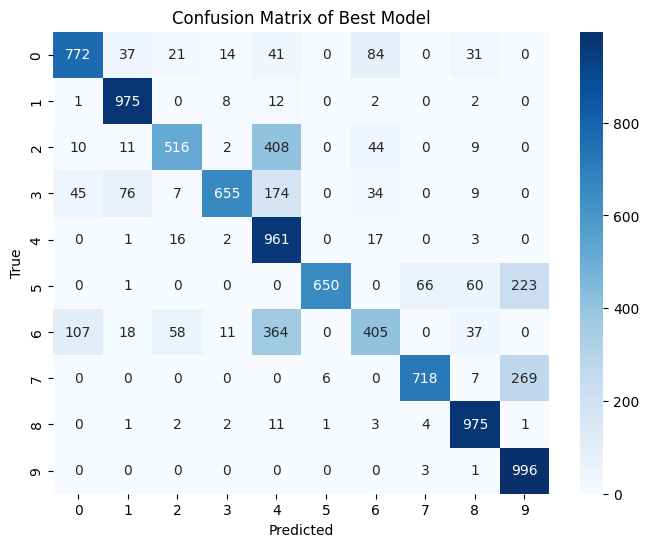

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
accuracy,0.86974
epoch,10
loss,0.3665
test_accuracy,0.7623
test_loss,8.03029


In [25]:
wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation")

best_config = {
    "activation": "relu",
    "batch_size": 64,
    "epochs": 10,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "nadam",
    "weight_decay": 0.0005,
    "weight_init": "xavier"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a)
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = categorical_cross_entropy(y_test, a_test)
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 8

In [29]:
def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = squared_error_loss(y_batch, a)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = squared_error_loss(y_val, a_val)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = squared_error_loss(y_test, a_test)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(sweep_id, train_network, count=5)

wandb.finish()


wandb: Agent Starting Run: q7u08m40 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.25373921400916294, Accuracy: 0.6566268782127324, val_loss: 0.1918642407895258, val_accuracy: 0.717
Epoch 2, Loss: 0.1705606053173762, Accuracy: 0.7582789640173981, val_loss: 0.15704381447315885, val_accuracy: 0.7801666666666667
Epoch 3, Loss: 0.1482465167936593, Accuracy: 0.7918767299327798, val_loss: 0.1443275281508061, val_accuracy: 0.796
Epoch 4, Loss: 0.1413917647043213, Accuracy: 0.8029668347172795, val_loss: 0.13581559118520609, val_accuracy: 0.812
Epoch 5, Loss: 0.13615409035525164, Accuracy: 0.8111778370897588, val_loss: 0.1337656719895876, val_accuracy: 0.8146666666666667
Epoch 6, Loss: 0.13500594240518884, Accuracy: 0.810881277184658, val_loss: 0.1338889361399052, val_accuracy: 0.8146666666666667
Epoch 7, Loss: 0.1329002003254442, Accuracy: 0.8138592328983788, val_loss: 0.13248797424899192, val_accuracy: 0.8166666666666667
Epoch 8, Loss: 0.13469800517025646, Accuracy: 0.8140136911822854, val_loss: 0.12727722398391703, val_accuracy: 0.8283333333333334
Epoch 9,

accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇██▇
val_loss,█▄▃▂▂▂▂▁▁▂
accuracy,0.81975
epoch,10
loss,0.12977
test_accuracy,0.7446


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3emv5idi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4507334540000461, Accuracy: 0.10041641953341242, val_loss: 0.45003613066321735, val_accuracy: 0.09433333333333334
Epoch 2, Loss: 0.4505640649538781, Accuracy: 0.1024614472123369, val_loss: 0.44999465466496713, val_accuracy: 0.098
Epoch 3, Loss: 0.4505478322881504, Accuracy: 0.10294335705812574, val_loss: 0.45008446575231803, val_accuracy: 0.14616666666666667
Epoch 4, Loss: 0.45052076572829286, Accuracy: 0.10357354685646501, val_loss: 0.4500423081602017, val_accuracy: 0.09433333333333334
Epoch 5, Loss: 0.450512491905741, Accuracy: 0.10404310003954131, val_loss: 0.4498740358649097, val_accuracy: 0.1055
Epoch 6, Loss: 0.4504699255344397, Accuracy: 0.10588424278370898, val_loss: 0.44988570579889864, val_accuracy: 0.09666666666666666
Epoch 7, Loss: 0.4504465283258777, Accuracy: 0.10775627718465797, val_loss: 0.4499226288497171, val_accuracy: 0.0995
Epoch 8, Loss: 0.4504166055686062, Accuracy: 0.10598927441676552, val_loss: 0.44975882674267315, val_accuracy: 0.10533333333333

accuracy,▁▂▂▃▃▄▅▄▄█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▅▄▄▃▃▂▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁█▁▃▁▂▂▅▃
val_loss,▇▆█▇▃▄▅▁▁▂
accuracy,0.11453
epoch,10
loss,0.45033
test_accuracy,0.137


wandb: Agent Starting Run: 0ivbnjlm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 0.38400040503747374, Accuracy: 0.5774639185448793, val_loss: 0.3170817653676351, val_accuracy: 0.6463333333333333
Epoch 2, Loss: 0.3065858301569804, Accuracy: 0.6578192961644919, val_loss: 0.2871541285060234, val_accuracy: 0.676
Epoch 3, Loss: 0.2982060372032742, Accuracy: 0.6629102412020562, val_loss: 0.32826284557313473, val_accuracy: 0.618
Epoch 4, Loss: 0.2898270169887956, Accuracy: 0.6720418149466192, val_loss: 0.3088875177468559, val_accuracy: 0.6531666666666667
Epoch 5, Loss: 0.2863343454591537, Accuracy: 0.6731909845788849, val_loss: 0.3348634801147851, val_accuracy: 0.6195
Test Loss: 2.791790830007047, Test Accuracy: 0.625


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▄█▁▅▁
val_loss,▅▁▇▄█
accuracy,0.67319
epoch,5
loss,0.28633
test_accuracy,0.625


wandb: Agent Starting Run: b9pjz2e2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 0.2621824733910016, Accuracy: 0.6134959470146303, val_loss: 0.20168470203185962, val_accuracy: 0.7026666666666667
Epoch 2, Loss: 0.18646532480574785, Accuracy: 0.7287280051403717, val_loss: 0.18948877124179936, val_accuracy: 0.7241666666666666
Epoch 3, Loss: 0.16930961913730558, Accuracy: 0.7570494760775011, val_loss: 0.1705390807475267, val_accuracy: 0.753
Epoch 4, Loss: 0.15855540229825574, Accuracy: 0.7737803973902728, val_loss: 0.16631905286097515, val_accuracy: 0.7621666666666667
Epoch 5, Loss: 0.15193069105712434, Accuracy: 0.7826463028865165, val_loss: 0.15854768090869498, val_accuracy: 0.7745
Epoch 6, Loss: 0.1462172916490854, Accuracy: 0.7910611901937525, val_loss: 0.1533155307683843, val_accuracy: 0.7818333333333334
Epoch 7, Loss: 0.14135349844216286, Accuracy: 0.7997046757611703, val_loss: 0.14839304327856245, val_accuracy: 0.79
Epoch 8, Loss: 0.13745347389573542, Accuracy: 0.8057470838275997, val_loss: 0.14615504451709183, val_accuracy: 0.7925
Epoch 9, Loss: 

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▇▄▄▃▂▂▂▁▁
accuracy,0.81463
epoch,10
loss,0.13117
test_accuracy,0.7685


wandb: Agent Starting Run: c9czc6j0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3807511965178222, Accuracy: 0.29660315342032423, val_loss: 0.22818005218778262, val_accuracy: 0.6576666666666666
Epoch 2, Loss: 0.17619990345910036, Accuracy: 0.735184361407671, val_loss: 0.14447379642809988, val_accuracy: 0.7876666666666666
Epoch 3, Loss: 0.14378672162997913, Accuracy: 0.7906101720047449, val_loss: 0.13232148939925734, val_accuracy: 0.8086666666666666
Epoch 4, Loss: 0.12664148986794305, Accuracy: 0.8197162910241202, val_loss: 0.12171383936590613, val_accuracy: 0.8281666666666667
Epoch 5, Loss: 0.11562908044932972, Accuracy: 0.8377384835903519, val_loss: 0.1142873483159412, val_accuracy: 0.8388333333333333
Epoch 6, Loss: 0.10744119303267169, Accuracy: 0.8494217081850534, val_loss: 0.10674703121331872, val_accuracy: 0.8518333333333333
Epoch 7, Loss: 0.10143081275602335, Accuracy: 0.858244365361803, val_loss: 0.10134984861708185, val_accuracy: 0.8565
Epoch 8, Loss: 0.09777670300573059, Accuracy: 0.8629028272044287, val_loss: 0.09809467150966013, val_accu

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,0.87423
epoch,10
loss,0.08989
test_accuracy,0.8281


Epoch 1, Loss: 0.41426061665938657, Accuracy: 0.21836076512455516
Epoch 2, Loss: 0.1897691058599156, Accuracy: 0.7139803281929616
Epoch 3, Loss: 0.14526893990041187, Accuracy: 0.7887690292605772
Epoch 4, Loss: 0.12560392844058146, Accuracy: 0.8215512554369316
Epoch 5, Loss: 0.114120752067384, Accuracy: 0.8403333827599841
Epoch 6, Loss: 0.10636964901169872, Accuracy: 0.8506573744563068
Epoch 7, Loss: 0.09886955269957934, Accuracy: 0.861685695927244
Epoch 8, Loss: 0.0958099754872548, Accuracy: 0.866585112692764
Epoch 9, Loss: 0.09027307438736665, Accuracy: 0.8748208283906683
Epoch 10, Loss: 0.08703867118409513, Accuracy: 0.8780829873467775
Evaluating on Test Set...
Test Loss: 0.11647800381032336, Test Accuracy: 0.8418


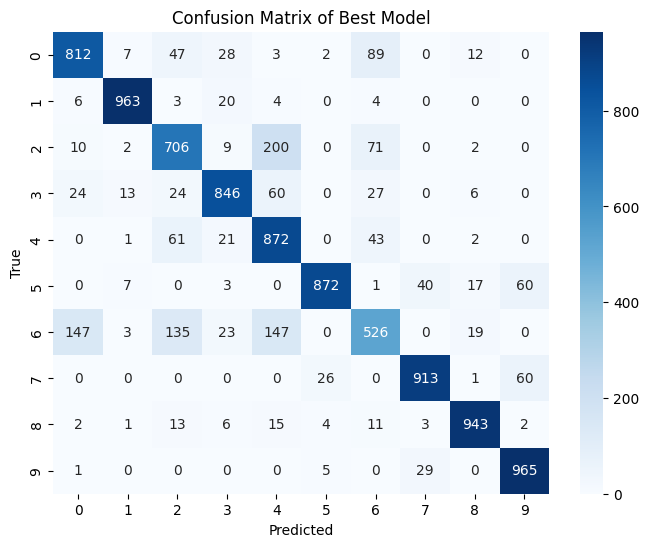

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
accuracy,0.87808
epoch,10
loss,0.08704
test_accuracy,0.8418
test_loss,0.11648


In [31]:
wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation")

best_config = {
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 10,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 4,
    "optimizer": "momentum",
    "weight_decay": 0.5,
    "weight_init": "xavier"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = squared_error_loss(y_batch, a)
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = squared_error_loss(y_test, a_test)
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()